NameError: name 'data' is not defined

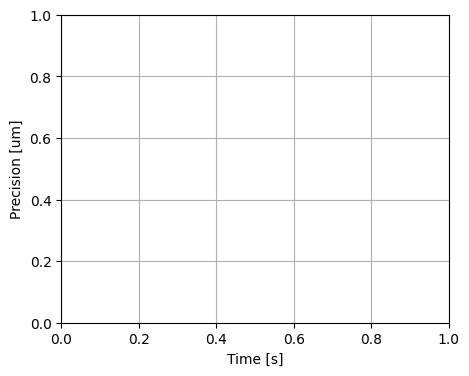

In [1]:
import sys
from PySide6 import QtWidgets
from PySide6 import QtCore
from PySide6 import QtGui
from PySide6.QtGui import *
from PySide6.QtWidgets import *
from PySide6.QtCore import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas

from scipy.fft import fft
import ctypes
myappid = 'nil.npm.pyqt.2' # arbitrary string
ctypes.windll.shell32.SetCurrentProcessExplicitAppUserModelID(myappid)
import warnings
warnings.filterwarnings("ignore")

from importlib import reload
import ui_grapher
reload(ui_grapher)
from ui_grapher import *

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None):
        fig, self.ax = plt.subplots(figsize=(5, 4))  # You can set the figure size here
        super().__init__(fig)
        
        # Plot voltage vs time
        self.ax.set_xlabel('Time [s]')
        self.ax.set_ylabel('Precision [um]')
        self.ax.grid()

    def savePlot(self, filename):
        self.figure.savefig(filename)  # Save the figure to a file

class MainWindow(QtWidgets.QMainWindow, Ui_MainWindow): # main window
    def __init__(self):
        super(MainWindow, self).__init__()
        self.setupUi(self)

        self.truth=True

        self.setWindowTitle("Plotter")

        # Create and add the Matplotlib canvas to the layout
        self.canvas = MplCanvas(self)
        self.plotLayout.addWidget(self.canvas)

        # Initializing plot objects for updating
        self.t, self.v = zip(*data['1_-1V 30 sec.avi'])
        x, v = self.kalmanFilter(self.v)
        self.noisy_line, = self.canvas.ax.plot(self.t, x, label='Noisy Velocity', color='red', alpha=0.5)
        self.filtered_line, = self.canvas.ax.plot(self.t, v, label='Filtered Velocity (Kalman)', color='blue', linewidth=2)
        
        self.bSlider.valueChanged.connect(self.onBSlider)
        self.tSlider.valueChanged.connect(self.onTSlider)
        self.rSlider.valueChanged.connect(self.onRSlider)
        
        self.timer = QTimer()
        self.timer.timeout.connect(self.updateGraph)
        self.timer.start(33)

        self.actionSave.triggered.connect(self.onSave)

    def onSave(self):
        self.canvas.savePlot('measurements vs simulation.png')

    def onBSlider(self):
        self.bValue.setValue(self.bSlider.value())
        
    def onTSlider(self):
        self.tValue.setValue(self.tSlider.value()/1e15)

    def onRSlider(self):
        self.rValue.setValue(self.rSlider.value()/1e13)
    
    def kalmanFilter(self, data):
        # Kalman filter parameters
        n_iter = len(data)
        z = data

        # Allocate space for arrays
        x = np.zeros(n_iter)
        P = np.zeros(n_iter)
        x[0] = z[0]
        P[0] = 1

        Q = self.tValue.value()  # Process noise covariance
        R = self.rValue.value()    # Measurement noise covariance

        # Kalman filter algorithm
        for k in range(1, n_iter):
            x_pred = x[k-1]
            P_pred = P[k-1] + Q

            K = P_pred / (P_pred + R)
            x[k] = x_pred + K * (z[k] - x_pred)
            P[k] = (1 - K) * P_pred

        return x, z
    
    def updateGraph(self):
        # Sample time and noisy velocity data (replace with your data)
        length = int(len(self.t) * self.bValue.value() / 100)

        if length < 10:
            return  # Prevent errors with too few data points

        time = self.t[:length]
        noisy_velocity = self.v[:length]

        x, z = self.kalmanFilter(noisy_velocity)

        # Update plot data without recreating the canvas
        self.noisy_line.set_data(time, z)
        self.filtered_line.set_data(time, x)

        # Rescale the axes
        self.canvas.ax.relim()
        self.canvas.ax.autoscale_view()

        # Redraw the canvas
        self.canvas.draw()

    def closeEvent(self, event):
        try:
            # Perform any other necessary cleanup tasks
            event.accept()  # Accept the event to close the window
            
            super().closeEvent(event)
        except Exception as e:
            print(f"Error during close event: {e}")
            event.ignore()  # Optionally ignore the event if cleanup fails
        print('\nExited')

if not QtWidgets.QApplication.instance():
    app = QtWidgets.QApplication(sys.argv)
else:
    app = QtWidgets.QApplication.instance()

if __name__ == '__main__':
    window = MainWindow()
    app.setStyle('Windows')
    window.show()
    print('Running\n')
    app.exec()